# Gravepine Disease Classification using Transfer Learning

In this work, we are going to use the advantages of Transfer Learning in the classification of the gravepine disease from leaf photos.
Since we have a relatively small dataset (almost 800 photos and 4 classes) it is very important to use such a technique to reach good accuracy.

### Import all libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
import tensorflow as tf

### Setting some params

We have 256x256 pixel photos, but the model that we are going to use require 160x160x3 (RGB) tensors.
We also choose 5 epochs and a learning rate equal to 1e-4.


In [2]:
PATH="../input/plantvillage-grape/Grape/"

BATCH_SIZE = 64
IMG_SIZE = (160, 160)
EPOCHS = 5
INIT_LR =1e-4

## Load the data

To load the data we use the Keras Data Generator, with a rescale of the pixel values and a train-validation split of .8/.2

Use class_mode = categorical beacuse we have to use a categorical cross entropy as a loss in the final fully conected part of the network. (The part that makes the classification)
This is used essentially to represent each class as a one hot vector.

In [3]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)    

train_ds = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=PATH,
                                                 shuffle=True,
                                                 target_size=IMG_SIZE, 
                                                 subset="training",
                                                 class_mode='categorical')

val_ds = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=PATH,
                                                 shuffle=True,
                                                 target_size=IMG_SIZE, 
                                                 subset="validation",
                                                 class_mode='categorical')



Found 3251 images belonging to 4 classes.
Found 811 images belonging to 4 classes.


### Rescale pixel values

In a moment, we will download `tf.keras.applications.MobileNetV2` for use as the base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 1]`. To rescale them, use the preprocessing method included with the model.preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_inputCreate a simple connvolutional model in tensorflow and then train it

In [4]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model from the pre-trained convnets
We will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, we need to pick which layer of MobileNet V2 we will use for **feature extraction**. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, we will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, we instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [5]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,) # R,G,B Channels
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

2022-04-21 16:18:46.899412: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step


In [6]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


## Create the entire network

Our network consist of a base model of MobileNetV2 pre-trained on the Imagenet dataset, and a fully connected final part that will trained to make our 4-class classification.

We freeze the MobileNet layers and train only the fully connected final layers. It's important to use a softmax activation function in final layer and a categorical cross entropy, since we are going to do a multi-class classification.

Mobilenet is a family of neural network that use Depthwise separable convolution, so are faster wrt the other deep architecture, and particular suitable for embedded applications.


In [7]:
# Add a global spatial average pooling layer
out = base_model.output
out = tf.keras.layers.GlobalAveragePooling2D()(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
predictions = tf.keras.layers.Dense(4, activation='softmax')(out)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers and use theyas feature extractor trained ln imagenet
for layer in base_model.layers:
    layer.trainable = False
    
# Compile 
opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

### Train the model

First, see the initial loss and initial accuracy. Then we train the fully connected layers for 5 epochs.

In [8]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


2022-04-21 16:18:51.069829: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


13/13 [==============================] - 9s 565ms/step - loss: 1.5985 - accuracy: 0.1319
initial loss: 1.60
initial accuracy: 0.13


In [9]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/5
51/51 [==============================] - 34s 609ms/step - loss: 0.4608 - accuracy: 0.8444 - val_loss: 0.1308 - val_accuracy: 0.9630
Epoch 2/5
51/51 [==============================] - 25s 496ms/step - loss: 0.1047 - accuracy: 0.9674 - val_loss: 0.0844 - val_accuracy: 0.9729
Epoch 3/5
51/51 [==============================] - 26s 501ms/step - loss: 0.0639 - accuracy: 0.9837 - val_loss: 0.0625 - val_accuracy: 0.9790
Epoch 4/5
51/51 [==============================] - 26s 506ms/step - loss: 0.0439 - accuracy: 0.9898 - val_loss: 0.0512 - val_accuracy: 0.9864
Epoch 5/5
51/51 [==============================] - 26s 508ms/step - loss: 0.0352 - accuracy: 0.9914 - val_loss: 0.0436 - val_accuracy: 0.9864


### Plotting the training results

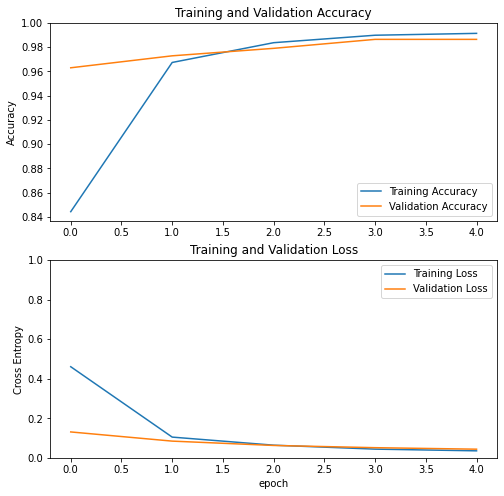

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

Unfreeze a subset of the base model and train with our data, in order to gain some points of accuracy.

In [11]:
base_model.trainable = True

In [12]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [13]:
fine_tune_epochs = 5
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/10
51/51 [==============================] - 26s 510ms/step - loss: 0.0256 - accuracy: 0.9948 - val_loss: 0.0473 - val_accuracy: 0.9840
Epoch 6/10
51/51 [==============================] - 26s 510ms/step - loss: 0.0230 - accuracy: 0.9945 - val_loss: 0.0363 - val_accuracy: 0.9889
Epoch 7/10
51/51 [==============================] - 25s 499ms/step - loss: 0.0193 - accuracy: 0.9951 - val_loss: 0.0322 - val_accuracy: 0.9901
Epoch 8/10
51/51 [==============================] - 26s 512ms/step - loss: 0.0111 - accuracy: 0.9988 - val_loss: 0.0295 - val_accuracy: 0.9914
Epoch 9/10
51/51 [==============================] - 26s 506ms/step - loss: 0.0087 - accuracy: 0.9997 - val_loss: 0.0322 - val_accuracy: 0.9901
Epoch 10/10
51/51 [==============================] - 26s 504ms/step - loss: 0.0072 - accuracy: 0.9994 - val_loss: 0.0275 - val_accuracy: 0.9889


In [14]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

### Plotting fine-tuning results

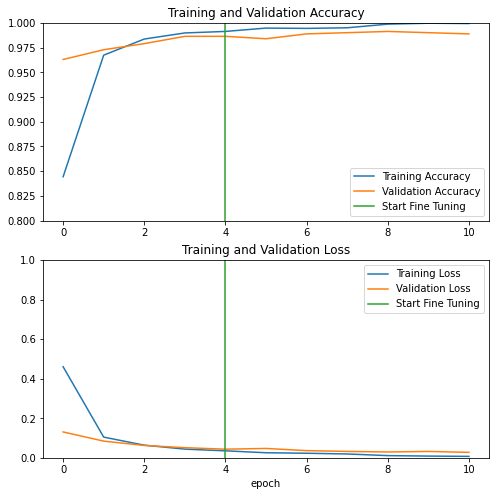

In [15]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()